In [1]:
%matplotlib inline

# Predicting Continuous target variables with regression analysis

Regression models are used to predict target variables on a continuous scale.  This is useful for:
1. understanding the relationships between variables.
2. evaluating trends.
3. making forecasts.

In this chapter, we will discuss the main concepts of regression models and cover the following topics:

- Exploring and visualising datasets.
- Looking at different approaches to implement linear regression models.
- Training regression models that are robust to outliers.
- Evaluating regression models and diagnosing common problems.
- Fitting regression models to non-linear data.

# Introducing linear regression
The goal of linear regression is to model the relationship between one or multiple features and a continuous target variable.  Regression analysis aims to predict outputs on a continuous scale, rather than categorical class labels.

## Simple linear regression
The goal of simple **univariate** linear regression is to model the relationship between a single feature (**explanatory variable** $x$) and a continuous valued **response** (**target variable** $y$).  The equation of a linear model with one explanatory variable is defined as follows:
$$
y = w_0 + w_1x
$$

Here, the weight $w_0$ represents the y-axis intercept, and $w_1$ is the weight coefficient of the explanatory variable.  Our goal is to learn the weights of the linear equation to describe the relationship between the explanatory variable and the target variable.

Linear regression can be understood as finding the best-fitting straight line through sample points, as shown in the following figure:

<img src="images/10_01.png" style="width:500px;">

The best-fitting line is also called the **regression line**, and the vertical lines from the regression line to the sample points are the so-called **offsets** or **residuals** -- the errors of our prediction.

## Multiple linear regression

In multiple linear regression we can generalise the linear regression model to multiple explanatory variables:

$$
y = w_0x_0 + w_1x_1 + \ldots + w_mx_m = \sum_{i=0}^{m}w_ix_i = w^T\mathbf{x}
$$

Here, $w_0$ is the y-axis intercept with $x_0=1$

## Exploring the Housing dataset
The Housing dataset contains information about houses in the suburbs of Boston, and were collected by D.Harrison and D.L Rubinfeld in 1978.

## Loading the Housing dataset into a data frame
For the rest of this chapter, we will regard the house prices (```MEDV```) as our target variable --- the variable that we wnt to predict using one or more of the 13 explanatory variables.  Before we explore this dataset further, let us load it into a Pandas DataFrame:

In [2]:
import pandas as pd

df = pd.read_csv("housing_data.txt", header=None, sep="\s+")
df.columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
              "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Visualising the important characteristics of a dataset

A **scatterplot** matrix allows us to visualise the pair-wise correlations between different features in a dataset in one place.

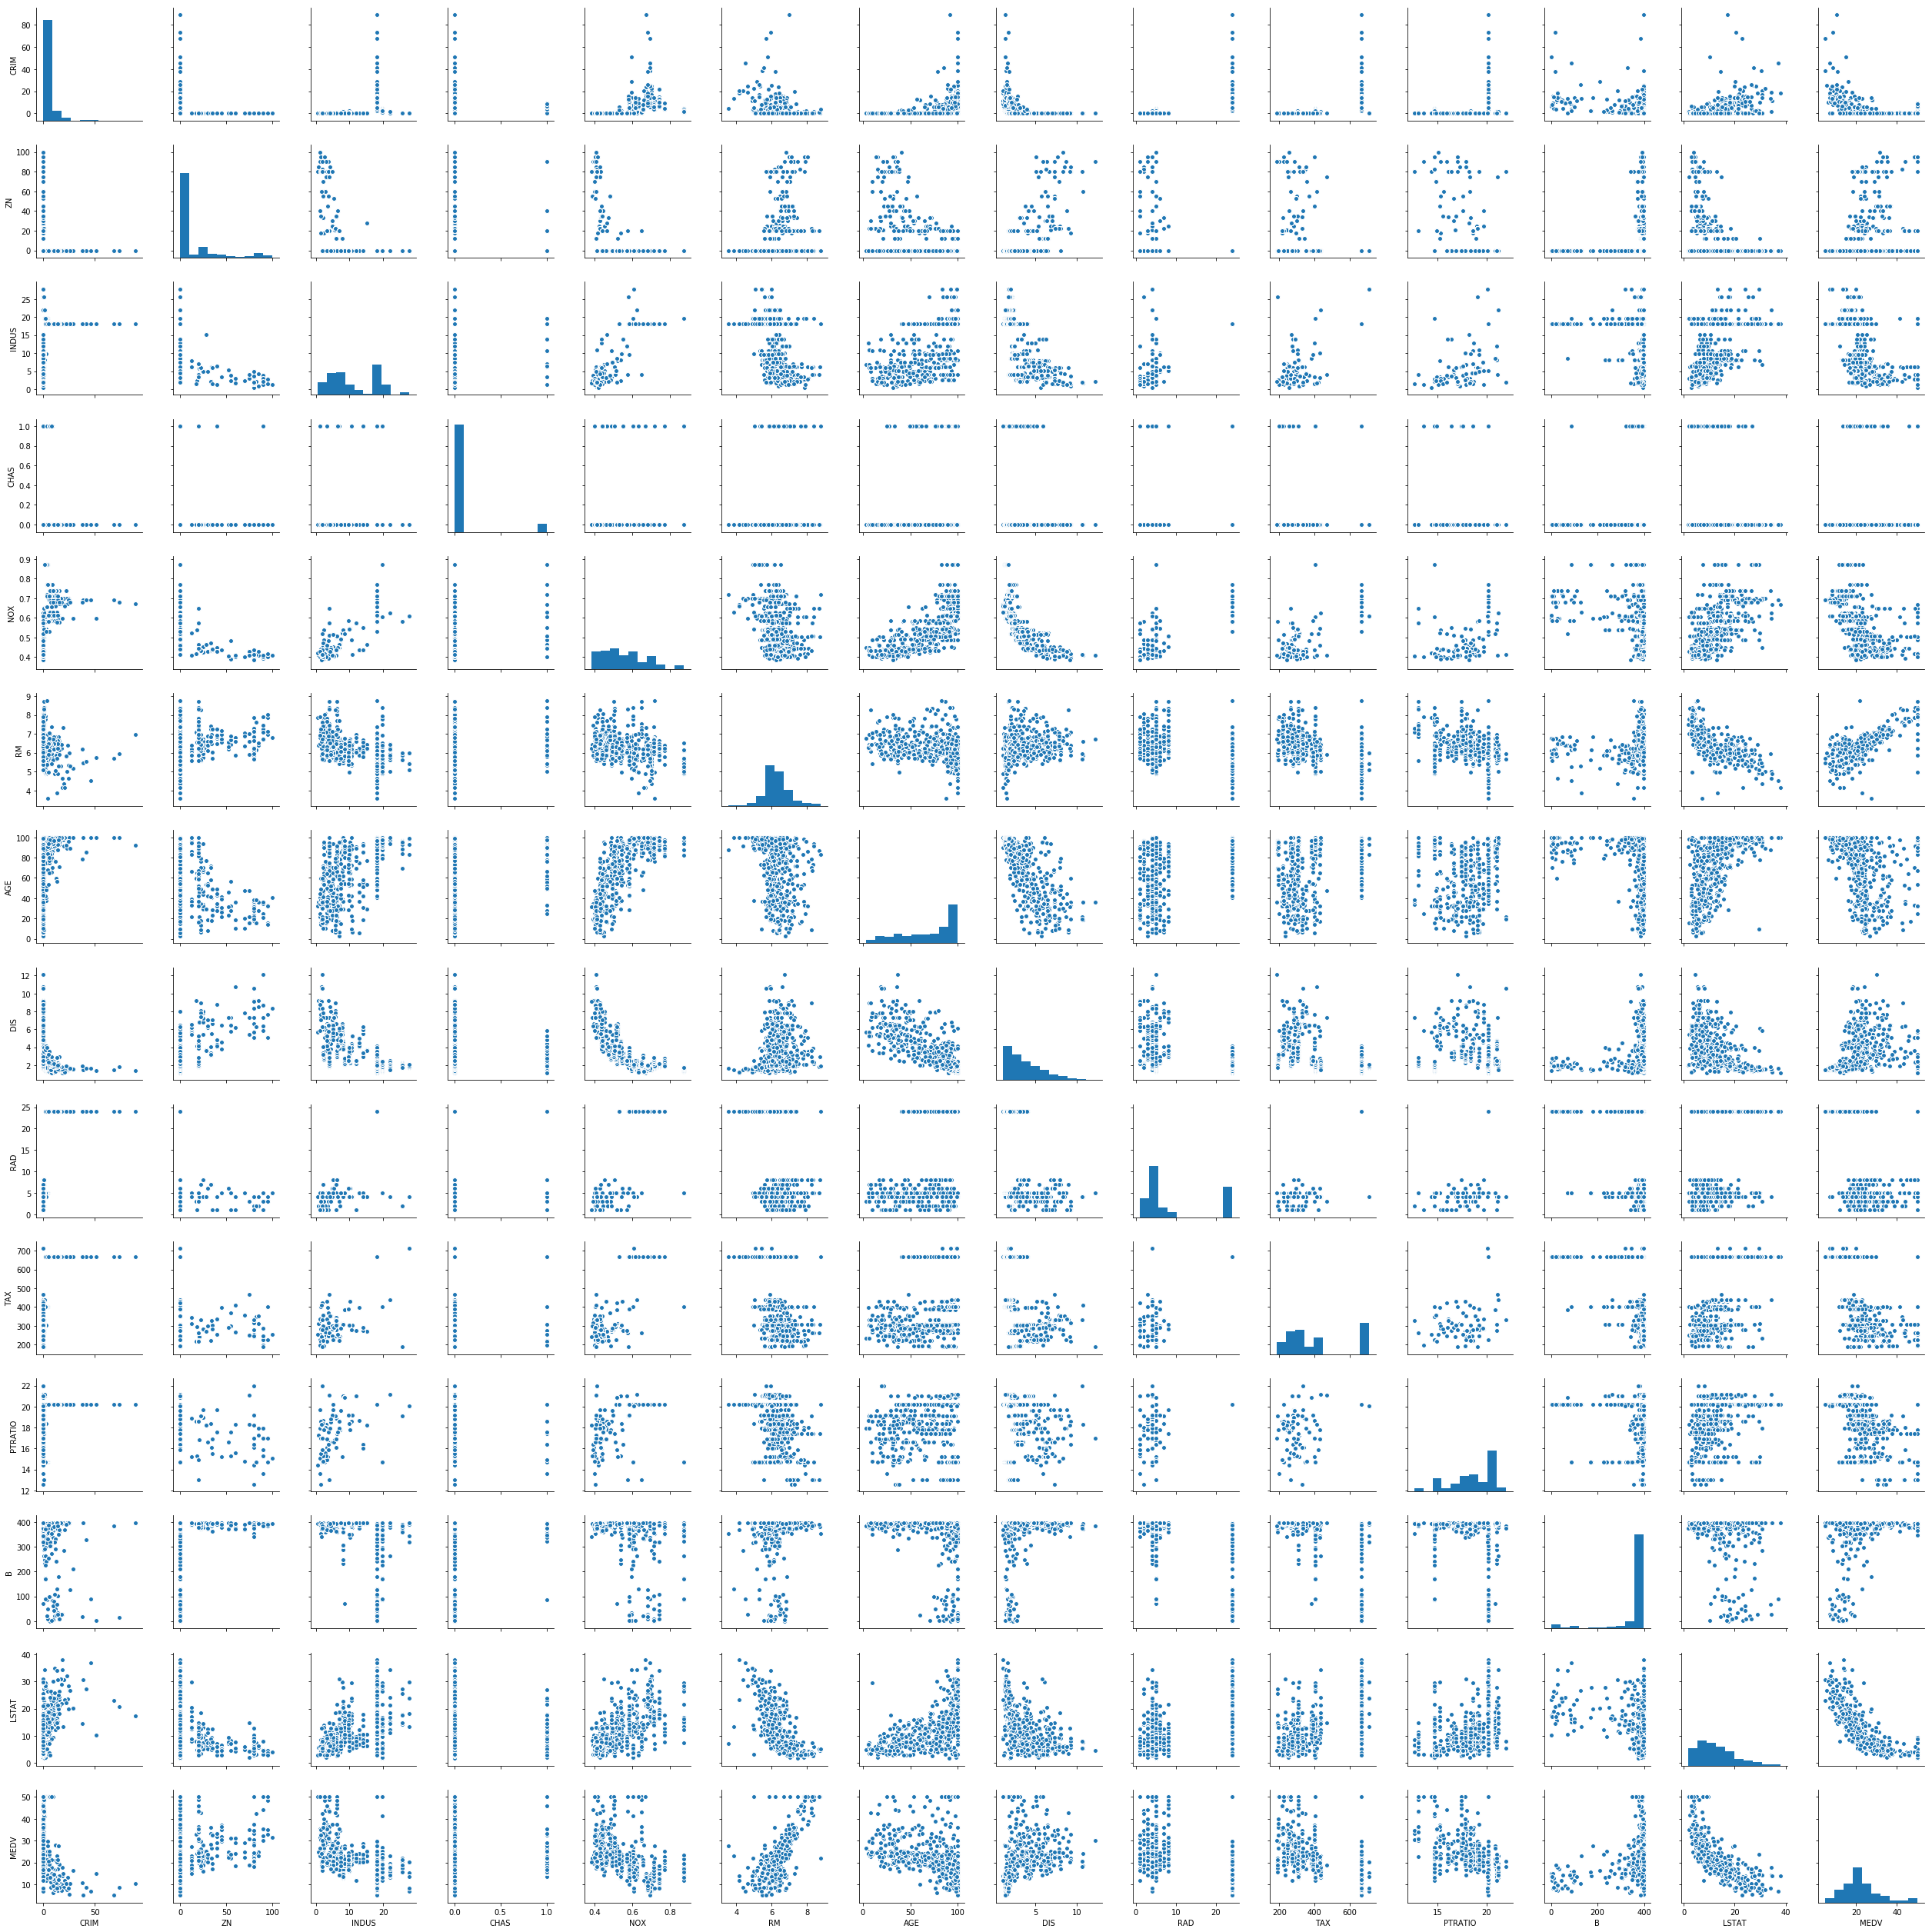

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(df)
plt.tight_layout()
plt.show()

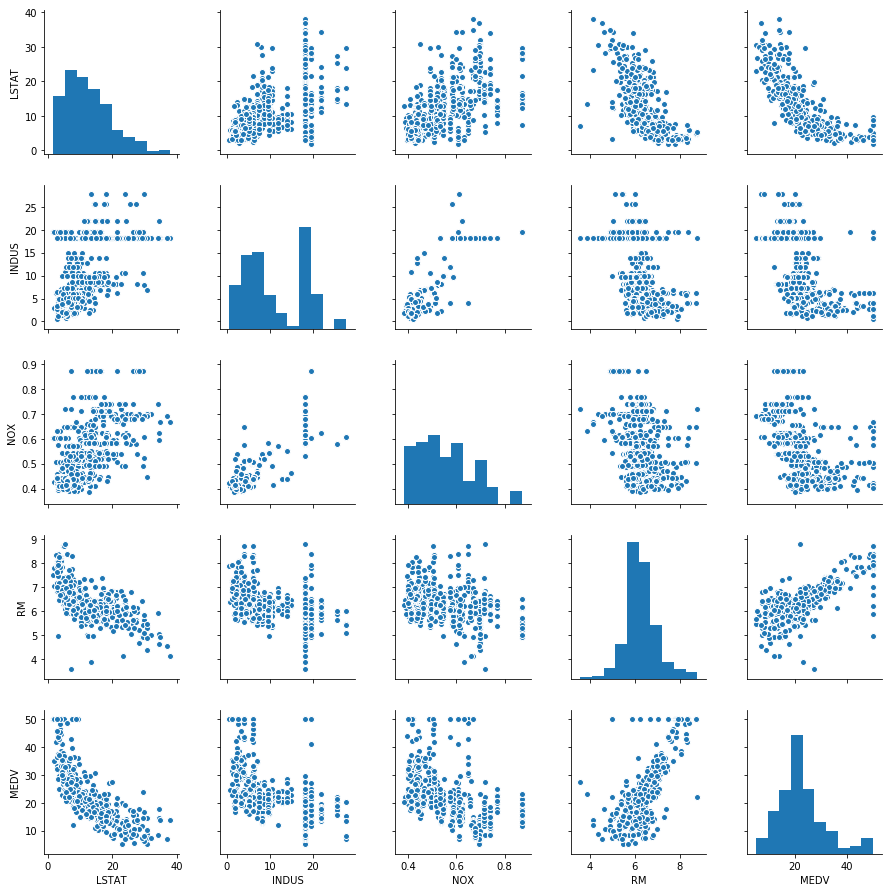

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
cols = ["LSTAT", "INDUS", "NOX", "RM", "MEDV"]
sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
plt.show()

Contrary to common belief, training a linear regression model does not require that the explanatory or target variables to be normally distributed.

## Looking at the relationships using a correlation matrix

A correlation matrix is a rescaled version of the covariance matrix.  In fact, the correlation matrix is identical to a covariance matrix computed form standardised features.

The correlation matrix is a square matrix that contains the **Pearson product-moment correlation coefficient** (often abbreviated as **Pearson's r**), which measures the linear dependence between pairs of features.

- Two features have a perfect positive correlation if $r=1$.
- Two features have no correlation if $r=0$.
- Two features have a perfect negative correlation if $r=-1$.

Pearson's correlation coefficient can simply be calculated as the covariance between two features $x$ and $y$ divided by the product of their standard deviations:

$$
r = \frac{\sum_{i=1}^{n}\left[ \left( x^{(i)} - \mu_x \right)\left( y^{(i)} - \mu_y \right) \right]}{\sqrt{\sum_{i=1}^{n}\left( x^{(i)} - \mu_x \right)^2}\sqrt{\sum_{i=1}^{n}\left( y^{(i)} - \mu_y \right)^2}} = \frac{\sigma_{xy}}{\sigma_x \sigma_y}
$$

Here, $\mu$ denotes the sample mean of the corresponding feature, $\sigma_{xy}$ is the covariance between the features $x$ and $y$, and $\sigma_x$ and $\sigma_y$ are the features' standard deviations.

In the following code example, we will use NumPy's ```corrcoef``` function on the five feature columns that we previously visualised in the scatterplot matrix, and we will use Seaborn's ```heatmap``` function to plot the correlation matrix array as a heat map:

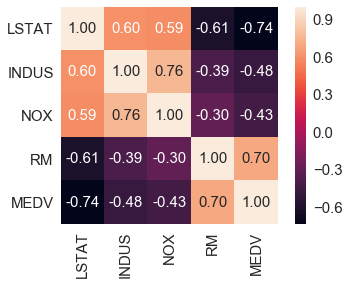

In [5]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt=".2f",
                 annot_kws={"size":15},
                 yticklabels=cols,
                 xticklabels=cols)
plt.show()

## Implementing an ordinary least squares linear regression model

**Ordinary Least Squares (OLS)** is used to estimate the parameters of the linear regression line that minimises the sum of the squared vertical distances (residuals or errors) to the sample points.

In [6]:
class LinearRegressionGD(object):
    
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter
        
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)
        
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        # In Univariate case, w_0 and w_1 are initialised to 0.
        # Therefore, the very first instance of output produces a list of 0's.
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = y - output  # actual minus calculated/predicted
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self    

In [7]:
X = df[["RM"]].values
print("type(X) = {}.".format(type(X)))
print("X.shape = {} rows, {} column(s).".format(X.shape[0], X.shape[1]))
print("X.size = {}.".format(X.size))
print("X[5:10, 0] = {}.".format(X[5:10, 0]))
y = df["MEDV"].values
print("#"*80)
print("type(y) = {}.".format(type(y)))
print("y.shape = {}.".format(y.shape))
print("y.size = {}.".format(y.size))
print("y[5:10] = {}.".format(y[5:10]))
print("#"*80)
#print("X = {}.".format(X))
#print("#"*80)
#print("y = {}.".format(y))
#print("#"*80)

type(X) = <class 'numpy.ndarray'>.
X.shape = 506 rows, 1 column(s).
X.size = 506.
X[5:10, 0] = [6.43  6.012 6.172 5.631 6.004].
################################################################################
type(y) = <class 'numpy.ndarray'>.
y.shape = (506,).
y.size = 506.
y[5:10] = [28.7 22.9 27.1 16.5 18.9].
################################################################################


To see our ```LinearRegressionGD``` in action, let us use the ```RM``` variable from the Housing dataset as the explanatory variable and train a model that can predict ```MEDV``` (house prices).  Furthermore, we will standardise the variables for better convergence of the GD algorithm.  The code is as follows:

In [8]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

print("lr.w_[1:] = {}.".format(lr.w_[1:]))
print("lr.w_[0] = {}.".format(lr.w_[0]))
print("lr.cost_[0] = {:.2f}.".format(lr.cost_[0]))
print("lr.cost_[-1] = {:.2f}.".format(lr.cost_[-1]))

lr.w_[1:] = [0.69535943].
lr.w_[0] = -4.831690603168682e-16.
lr.cost_[0] = 253.00.
lr.cost_[-1] = 130.67.


Notice the workaround regarding ```y_std```, using ```np.newaxis``` and ```flatten```.  Most transformers in scikit-learn expect the data to be stored in 2d arrays.  In the previous code example, the use of ```np.newaxis``` in ```y[:, np.newaxis]``` added a new dimension to the array.  Then, after the ```StandardScaler``` returned the scaled variable, we converted it back to the original 1d array representation using the ```flatten()``` method for our convenience.

In Chapter 2, we discussed that it is always a good idea to plot the cost as a function of the number of epoch passes over the training dataset when we are using optimisation algorithms, such as gradient descent, to check that the algorithm converged to a cost minimum here (here, a _global_ cost minimum.)

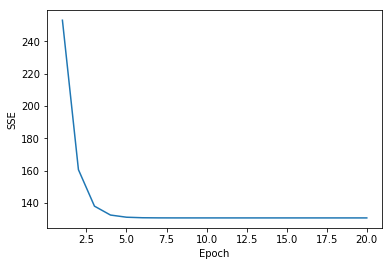

In [9]:
sns.reset_orig() # resets the matplotlib style
plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel("SSE")
plt.xlabel("Epoch")
plt.show()

Next, let us visualise how well the linear regression line fits the training data.  To do so, we will define a simple helper function that will plot a scatterplot of the training samples and add the regression line.

In [10]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c="steelblue", edgecolor="white", s=70)
    plt.plot(X, model.predict(X), color="black", lw=2)

Now, we will use this ```lin_regplot``` function to plot the number of rooms against the house price:

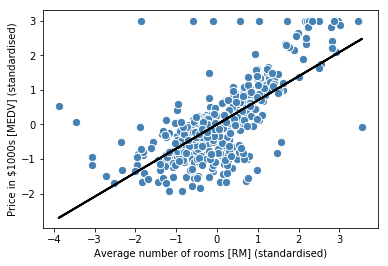

In [11]:
lin_regplot(X_std, y_std, lr)
plt.xlabel("Average number of rooms [RM] (standardised)")
plt.ylabel("Price in $1000s [MEDV] (standardised)")
plt.show()

As we can see, the linear regression line reflects the general trend that house prices tend to increase with the number of rooms.

In order to scale the predicted price outcome back onto the original ```Price in 1000s``` axis, we can simply apply the ```inverse_transform``` method of the ```StandardScaler```: 

In [12]:
num_rooms_std = sc_x.transform([[5.0]])
price_std = lr.predict(num_rooms_std)

print("Price in $1000s: {:.3f}.".format(sc_y.inverse_transform(price_std)[0]))

Price in $1000s: 10.840.


In this code example, we used the previously trained linear regression model to predict the price of a house with 5 rooms.  According to our model, such a house is worth $10 840.

On a side node, we technically don't have to update the weights of the intercept if we are working with standardised variables since the $y$-axis intercept is always 0 in those cases.  We can quickly confirm this by printing the weights:

In [13]:
print("Slope: {:.3f}.".format(lr.w_[1]))
print("Intercept {:.3f}.".format(lr.w_[0]))

Slope: 0.695.
Intercept -0.000.


## Estimating coefficients of a regression model via scikit-learn

Slope: 9.102.
Intercept: -34.671.


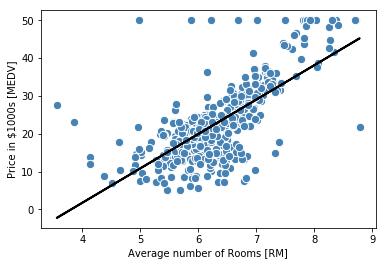

In [14]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)

print("Slope: {:.3f}.".format(slr.coef_[0]))
print("Intercept: {:.3f}.".format(slr.intercept_))

lin_regplot(X, y, slr)
plt.xlabel("Average number of Rooms [RM]")
plt.ylabel("Price in $1000s [MEDV]")
plt.show()

## Fitting a robust model using RANSAC

RANSAC = RANdom SAmple Consensus algorithms fit a regression model to a subset of the data, the so-called **inliers**.  We can summarise the iterative RANSAC algorithms as follows:

1. Select a random number of samples to be inliers, and then fit the model.
2. Test all other data points against the fitted model, and add those points that fall within a user-given tolerance to the inliers.
3. Refit the model using all the inliers.
4. Estimate the error of the fitted model versus the inliers.
5. Terminate the algorithm if the performance meets a certain user-defined threshold or if a fixed number of iterations were reached; go back to step 1 otherwise.

Let us now wrap our linear model in the RANSAC algorithm using scikit-learn's ```RANSACRegressor``` class:

In [15]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=50,
                         loss='absolute_loss',
                         residual_threshold=5.0,
                         random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_metric=None, residual_threshold=5.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

By default, scikit-learn uses the **MAD** estimate to select the inlier threshold, where MAD stands for **Median Absolute Deviation** of the target values $y$.  However, the choice of an appropriate value for the inlier threshold is problem-specific, which is one disadvantage of RANSAC.

After we fit the RANSAC model, let's obtain the inliers and outliers from the fitted RANSAC-linear regression model and plot them together with the linear fit:

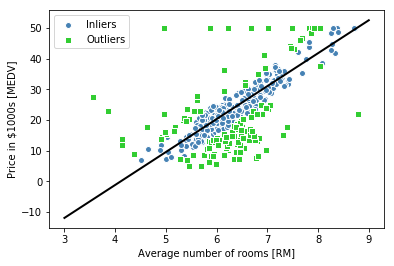

In [16]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3,10,1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask],
            c="steelblue", edgecolor="white",
            marker="o", label="Inliers")
plt.scatter(X[outlier_mask], y[outlier_mask],
            c="limegreen", edgecolor="white",
            marker="s", label="Outliers")
plt.plot(line_X, line_y_ransac, color="black", lw=2)
plt.xlabel("Average number of rooms [RM]")
plt.ylabel("Price in $1000s [MEDV]")
plt.legend(loc="upper left")
plt.show()

As we can see in the scatterplot, the linear regression model was fitted on the detected set of inliers, shown as circles.

Let us now print the slope and the intercept of the model:

In [17]:
print("Slope: {:.3f}.".format(ransac.estimator_.coef_[0]))
print("Intercept: {:.3f}.".format(ransac.estimator_.intercept_))

Slope: 10.735.
Intercept: -44.089.


## Evaluating the performace of linear regression models

Instead of proceeding with the simple regression model, we will now use all the variables in the dataset and train a multiple regression model:

In [18]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

Residual plots are a commonly used graphical tool for diagnosing regression models.  They can help detect nonlinearity and outliers, and check whether the errors are randomly distributed.

Using the following code, we will now plot a residual plot where we simply subtract the true target variables from our predicted responses:

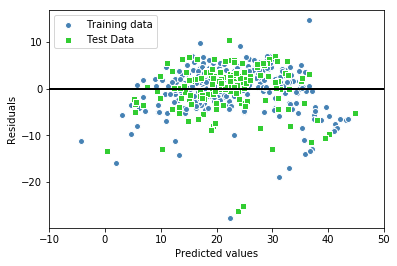

In [19]:
plt.scatter(y_train_pred, y_train_pred - y_train,
            c="steelblue", marker="o", edgecolor="white",
            label="Training data")
plt.scatter(y_test_pred, y_test_pred - y_test,
            c="limegreen", marker="s", edgecolor="white",
            label="Test Data")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=-10, xmax=50, color="black", lw=2)
plt.xlim([-10, 50])
plt.show()

For a good regression model, we would expect that the errors are randomly distributed and that the residuals should be randomly scattered around the centerline.  If we see a patter in a residual plot, it means that our model is unable to capture some explanatory information, which has leaked into the residuals.

Another useful quantitative measure of a model's performance is the so-called **Mean Squared Error (MSE)** which is simply the average value of the SSE cost that we minimised to fit the linear regression model.  The MSE is useful to compare different regression models or for tuning their parameters via grid search and cross-validation, as it normalises the SSE by the sample size:
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}\left( y^{(i)} - \hat{y}^{(i)} \right)^2
$$

Let us compute the MSE of our training and test predictions:

In [20]:
from sklearn.metrics import mean_squared_error
print("MSE train: {:.3f}, MSE test: {:.3f}.".format(mean_squared_error(y_train, y_train_pred), 
                                                    mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, MSE test: 27.196.


We see that the MSE on the training set is 19.96, and the MSE of the test set is much larger, with a vlaue of 27.20, which is an indicator that our model is overfitting the training data.

Sometimes, it may be more useful to report the **coefficient of determination** $(R^2)$, which can be understood as a standardised version of the MSE, for better interpretability of the model's performance.  Or in other words, $R^2$ is the fraciton of response variance that is cpatured by the model.  The $R^2$ value is defined as:
$$
R^2 = 1 - \frac{SSE}{SST}
$$

Here, SSE is the sum of squared errors and SST is the total sum of squares:
$$
SST = \sum_{i=1}^{n}\left( y^{(i)} - \mu_y \right)^2
$$
In other words, SST is simply the variance of the response.  Through simple algebra on page 331, it can be shown that $R^2$ is indeed just a rescaled version of the MSE.

For the training dataset, $R^2$ is bounded between 0 and 1, but it can become negative for the test set.  If $R^2 = 1$, the model fitsw the data perfectly with a corresponding $MSE=0$.

We can compute the $R^2$ by executing the following code:

In [21]:
from sklearn.metrics import r2_score
print("R^2 train: {:.3f}.".format(r2_score(y_train, y_train_pred)))
print("R^2 test: {:.3f}.".format(r2_score(y_test, y_test_pred)))

R^2 train: 0.765.
R^2 test: 0.673.


## Using regularised methods for regression

Regularisation is one approach to tackle the problem of overfitting by adding additional information, and thereby shrinking the parameter values of the model to induce a penatly against complexity.  The most popular approaches to regularised linear regression are the so-called **Ridge Regression**, **Least Absolute Shrinkage and Selection Operator (LASSO)**, and the **Elastic Net**.

Ridge regression is an L2 penalised model where we simply add the squared sum of the weights to our least-squares cost function:
$$
J(w)_{Ridge} = \sum_{i=1}^{n}\left( y^{(i)} - \hat{y}^{(i)} \right)^2 + \lambda ||{w}||_2^2
$$
where $\lambda||w||_2^2 = \lambda \sum_{j=1}^{m}w_j^2$

By increasing the value of the hyperparameter $\lambda$, we increase the regularisation strength and shrink the weights of our model.  Please note that we don't regularise the intercept term w_0.

An alternative approach that can lead to sparse models is LASSO.  Depending on the regularisation strength, certain weights can become zero, which also makes LASSO useful as a supervised feature selection technique:

$$
J(w)_{LASSO} = \sum_{i=1}^{n}\left( y^{(i)} - \hat{y}^{(i)} \right)^2 + \lambda||w||_1
$$
where, $\lambda||w||_1 = \lambda\sum_{j=1}^{m}|w_j|$.

However, a limitation of LASSI is that it selects at most $n$ vairables if $m>n$.  A compromise between Ridge regression and LASSO is Elastic Net, which has an L1 penalty to generate sparsity and an L2 penalty to overcome some of the limitations of LASSO, such as the number of selected variables.

A Ridge regression model can be initialised via:

In [22]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
# alpha is the regularisation strength; must be a positive float.

Likewise, we can initialise a LASSO regressor from the ```linear_model``` submodule:

In [23]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)
# alpha: Constant that multiplies the L1 term.  Defaults to 1.0.
# alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression object.

Lastly, the ```ElasticNet``` implementation allows us to vary the L1 to L2 ratio:

In [25]:
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)
# alpha: contant that multiplies the penalty terms.  Defaults to 1.0.
# alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression object.
# l1_ratio: The elasticnet mixing parameter, with 0 <= l1_ratio <= 1.
# l1_ratio = 0 the penalty is an L2 penalty.
# l1_ratio = 1 is an L1 penatly.
# For 0 < l1_ratio < 1, the penatly is a combination of L1 and L2

## Turning a linear regression model into a curve - polynomial regression

The polynomial regression model is given by:
$$
y = w_0 + w_1x + w_2x^2 + \ldots + w_dx^d
$$
where d denotes the degree of the polynomial.  Although we can use polynomial regression to model a nonlinear relationship, it is still considered a multiple linear regression model because of the linear regression coefficients $w$.

## Adding Polynomial terms using scikit-learn

We will now use the ```PolynomialFeatures``` transformer class from scikit-learn to add a quadratic term $(d=2)$ to a simple regression problem with one explanatory variable.  Then, we can compare the polynomial to the linear fit.

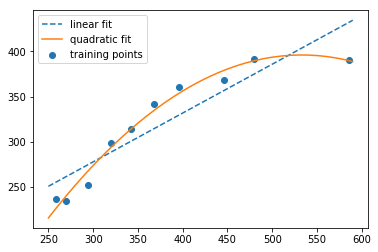

In [28]:
# Add a second degree polynomial term
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258, 270, 294, 320, 342, 368, 396, 446, 480, 586])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

# Fit a simple linear regression model for comparison
lr.fit(X, y)
X_fit = np.arange(250,600,10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# Fit a multiple regression model on the transformed features for polynomial regression
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# Plot the results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')
plt.show()

In the resulting plot, we can see that the polynomial fit captures the relationship between the response and explanatory variable much better than the linear fit.

In [32]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print("Training MSE linear: {:.3f}, quadratic: {:.3f}".format(mean_squared_error(y,y_lin_pred),
                                                              mean_squared_error(y,y_quad_pred)))
print("Training R^2 linear: {:.3f}, quadratic: {:.3f}".format(r2_score(y, y_lin_pred),
                                                              r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


## Modelling the nonlinear relationships in the Housing dataset

After we learned how to construct polynomial features to fit nonlinear relationships in a toy problem, let's now take a look at a more concrete example and apply those concepts to the data in the Housing dataset.  By executing the following code, we will model the reltionship between the house prices and ```LSTAT``` (percent lower status of the population) as using second degree (quadratic) and third degree (cubic) polynomials and compare it to the linear fit:

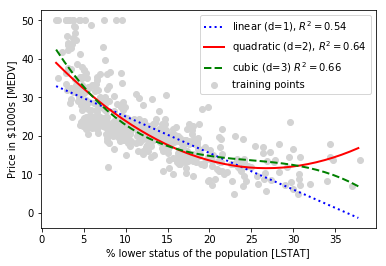

In [45]:
X = df[["LSTAT"]].values
y = df["MEDV"].values

regr = LinearRegression()

# Create the quadratic and cubic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit the features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# Plot the results
plt.scatter(X, y, label="training points", color="lightgray")

plt.plot(X_fit, y_lin_fit, 
         label="linear (d=1), $R^2 = {:.2f}$".format(linear_r2),
         color="blue", lw=2, linestyle=":")
plt.plot(X_fit, y_quad_fit, 
         label="quadratic (d=2), $R^2 = {:.2f}$".format(quadratic_r2),
         color="red", lw=2, linestyle="-")
plt.plot(X_fit, y_cubic_fit, 
         label="cubic (d=3) $R^2 = {:.2f}$".format(cubic_r2),
         color="green", lw=2, linestyle="--")
plt.xlabel("% lower status of the population [LSTAT]")
plt.ylabel("Price in $1000s [MEDV]")
plt.legend(loc="upper right")
plt.show()

As we can see, the cubic fit captures the relationship between house prices and LSTAT better than the linear and the quadratic fit.  However, we should be aware that adding more and more polynomial features increases the complexity of a model and therefore increases the chance of overfitting.  Thus, in practic it is always recommended to evaluate the performance of the model on a separate test dataset to estimate the generalisation performance.

In addition, polynomial features are not always the best choice for modelling non-linear relationships.  For example, with some experience or intuition, just looking at the MEDV-LSTAT scatterplot may lead to the hypothesis that a log-transformation of the LSTAT feature variable and the square root of MEDV may project the data onto a linear feature space suitable for alinear regression fit.  For instance, my perception is that this relationship between the two variables looks quite similar to an exponential function:
$$
f(x) = 2^{-x}
$$
Since the natural logarithm of an exponential function is a straing line, I assume that such a log-transformation can be usefully applied here:
$$
\log\left( f(x) \right) = -x
$$
Let's test this hypotheis by executing the following code:

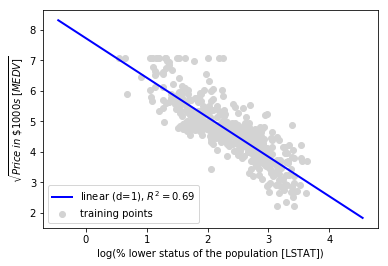

In [47]:
# transform the features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit the features
X_fit = np.arange(X_log.min() - 1, X_log.max() + 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot the results
plt.scatter(X_log, y_sqrt, label="training points", color="lightgray")
plt.plot(X_fit, y_lin_fit, label="linear (d=1), $R^2 = {:.2f}$".format(linear_r2),
         color="blue", lw=2)
plt.xlabel("log(% lower status of the population [LSTAT])")
plt.ylabel("$\sqrt{Price\; in\; \$1000s\; [MEDV]}$")
plt.legend(loc="lower left")
plt.show()

After transforming the explanatory onto the log space and taking the square root of the target variables, we we able to capture the relationship between the two variables with a linear regression line that seems to fit the data better $(R^2 = 0.69)$ than any of the polynomial feature transformations previously.

## Decision tree regression

To see what the line fit of a decision tree looks like, let us use the ```DecisionTreeRegressor``` implemented in scikit-learn to model the nonlinear relationship between the ```MEDV``` and the ```LSTAT``` variables:

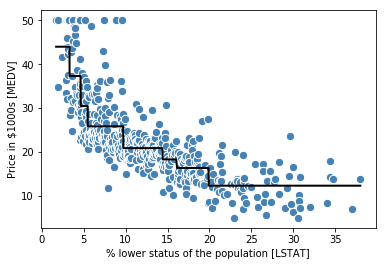

In [66]:
from sklearn.tree import DecisionTreeRegressor
X = df[["LSTAT"]].values
y = df["MEDV"].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel("% lower status of the population [LSTAT]")
plt.ylabel("Price in $1000s [MEDV]")
plt.show()

## Random Forest Regression

The random forest algorithm is an ensemble technique that combines multiple decision trees.  A random forest usually has a better generalisation performance than an individual decision tree due to randomness, which helps to decrease the model's variance.  Other advantes of random forests are that they are less sensitive to the outliers in the dataset and don't require much parameter tuning.  The only parameter in random forests that we typically need to experiment with is the number of trees in the ensemble.

The basic random forest algorithm for regression is almost identical to the random forest algorithm for classification that we dicussed in Chapter 3, the only difference is that we use the MSE criterion to grow the individual decision trees and the predicted target variable is calculated as the average prediction over all the decision trees.

Now, let's use all the features in the Housing dataset to fit a random forest regression model on 60% of the samples and evaluate its performance on the remaining 40%.  The code is as follows:

In [62]:
X = df.iloc[:, :-1].values
y = df["MEDV"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.4,
                                                    random_state=1)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000,
                               criterion="mse",
                               random_state=1,
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print("MSE train: {:.3f},"\ 
      "test {:.3f}".format(mean_squared_error(y_train, y_train_pred),
                           mean_squared_error(y_test, y_test_pred)))
print("R^2 train: {:.3f},"\
      "test {:.3f}".format(r2_score(y_train, y_train_pred),
                           r2_score(y_test, y_test_pred)))

MSE train: 1.642, test 11.052
R^2 train: 0.979, test 0.878


Unfortunately, we see that the random forest tends to overfit the training data.  However, it's still able to explain the relationship between the target and explanatory variables relatively well ($r^2 = 0.871$ on the test data).

Lastly, let us also take a look at the residuals of the prediction:

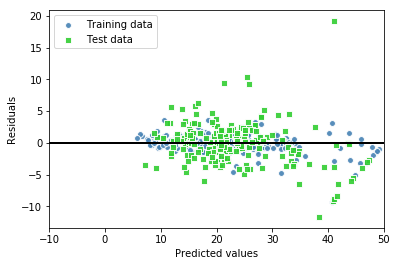

In [65]:
plt.scatter(y_train_pred, y_train_pred - y_train, color="steelblue", edgecolor="white",
            marker="o", s=35, alpha=0.9, label="Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, color="limegreen", edgecolor="white",
            marker="s", s=35, alpha=0.9, label="Test data")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color="black")
plt.xlim([-10, 50])
plt.show()

The model fits the trainig data better than the test data, as indiated by the outliers in the y-axis direction.  Also, the distribution of the residuals does not seem to be completely random around the zero center point, indicating that the model is not able to capture all the explanatory information.

However, the residual plot indicates a large improvement over the residual plot of the linear model that we plotted earlier in this chapter.

Ideally, our model error should be random or unpredictable.  In other words, the error of the predictions should not be related to any of the information contained in the explanatory variables, but should reflect the randomness of the real-word distributions or patterns.  If we observe patterns in the prediction errors for example by inspecting the residual plot, it means that the residual plots contain predictive information.  A common reason for this could be that explanatory information is leaking into those residuals.

Depending on the data that is available to us, we may be able to improve the model by transforming variables, tuning the hyperparameters of the learning algorithm, choosing simpler or more complex models, removing outliers, or including additional variables.